# Will the Customer Accept the Coupon?

Coupon acceptance exploration using the in-vehicle coupon recommendation dataset.

## 1. Setup

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_theme(font_scale=1.1)


## 2. Load data

In [52]:
data = pd.read_csv('data/coupons.csv')
data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


## 3. Inspect and clean data

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [54]:
data.isna().mean().sort_values(ascending=False).head(10)

car                     0.991485
CoffeeHouse             0.017108
Restaurant20To50        0.014901
CarryAway               0.011905
RestaurantLessThan20    0.010249
Bar                     0.008436
destination             0.000000
passanger               0.000000
direction_opp           0.000000
direction_same          0.000000
dtype: float64

In [55]:
# Simple example strategy: drop rows with missing target Y and coupon
clean = data.dropna(subset=['Y', 'coupon']).copy()
clean.shape

(12684, 26)

## 4. Overall coupon acceptance

In [56]:
accept_rate = clean['Y'].mean()
print(f'Overall acceptance rate: {accept_rate:.2%}')

Overall acceptance rate: 56.84%


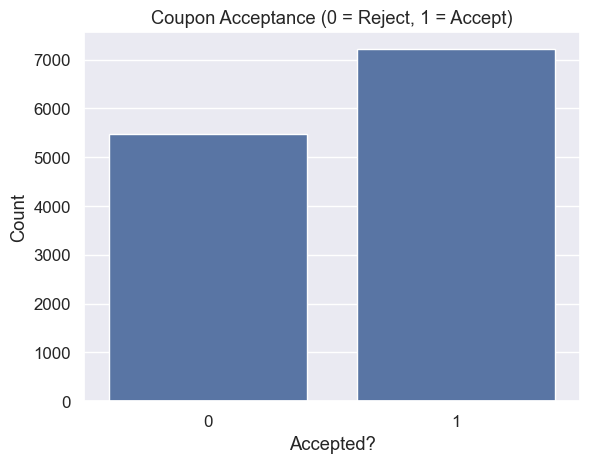

In [57]:
sns.countplot(data=clean, x='Y')
plt.title('Coupon Acceptance (0 = Reject, 1 = Accept)')
plt.xlabel('Accepted?')
plt.ylabel('Count')
plt.show()

## 5. Coupon type distribution

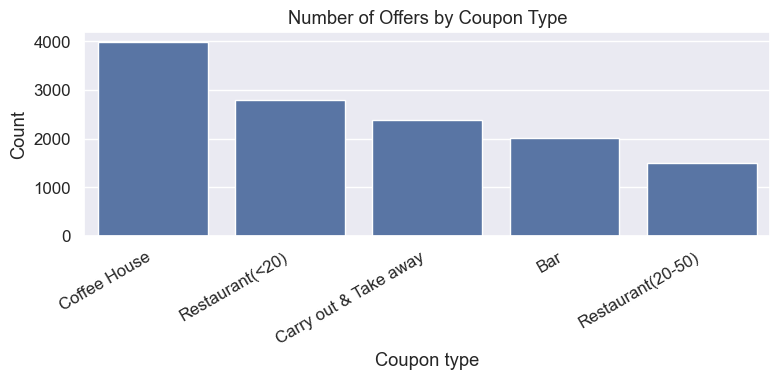

In [58]:
plt.figure(figsize=(8,4))
sns.countplot(data=clean, x='coupon', order=clean['coupon'].value_counts().index)
plt.title('Number of Offers by Coupon Type')
plt.xlabel('Coupon type')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

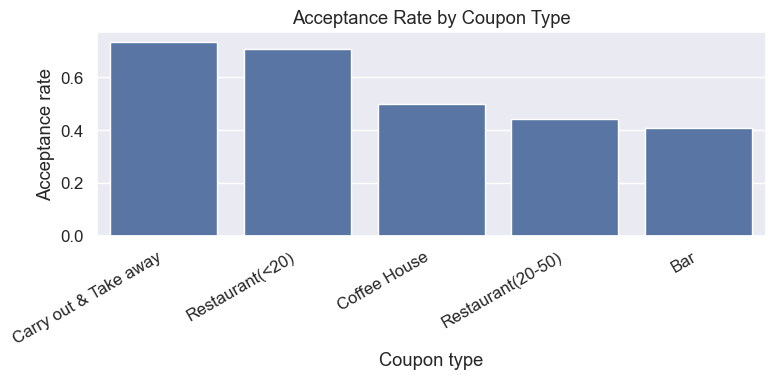

In [59]:
plt.figure(figsize=(8,4))
accept_by_type = clean.groupby('coupon')['Y'].mean().sort_values(ascending=False)
sns.barplot(x=accept_by_type.index, y=accept_by_type.values)
plt.title('Acceptance Rate by Coupon Type')
plt.xlabel('Coupon type')
plt.ylabel('Acceptance rate')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

6. Show histogram


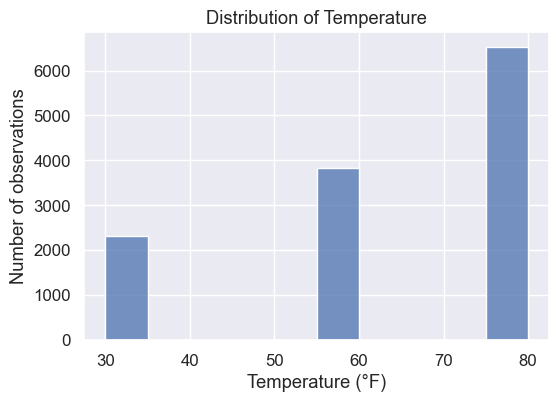

In [60]:
plt.figure(figsize=(6,4))
sns.histplot(data=clean, x="temperature", bins=10, kde=False)
plt.title("Distribution of Temperature")
plt.xlabel("Temperature (°F)")
plt.ylabel("Number of observations")
plt.show()


# Investigate bar coupons

1. Create a new `DataFrame` that contains just the `Bar` coupons.

In [74]:
# print("Results: ", clean["coupon"].unique())
# Results:  ['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar' 'Restaurant(20-50)']

bar_df = clean[clean['coupon'] == 'Bar'].copy()

2. What proportion of bar coupons were accepted?

In [79]:

bar_accept_rate = bar_df['Y'].mean()
print(f'Bar coupon acceptance rate: {bar_accept_rate:.2%}')

Bar coupon acceptance rate: 41.00%


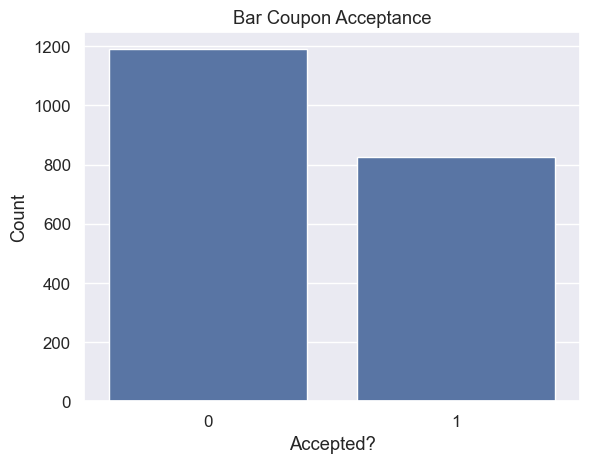

In [80]:
sns.countplot(data=bar_df, x='Y')
plt.title('Bar Coupon Acceptance')
plt.xlabel('Accepted?')
plt.ylabel('Count')
plt.show()

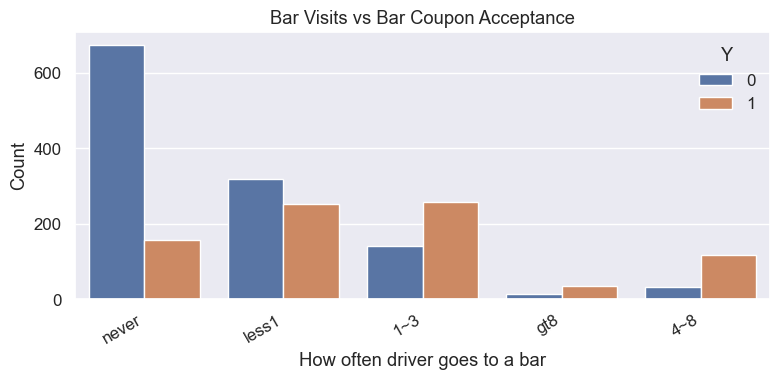

In [64]:
freq_col = 'Bar' if 'Bar' in bar_df.columns else 'Bar_freq'
if freq_col in bar_df.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data=bar_df, x=freq_col, hue='Y')
    plt.title('Bar Visits vs Bar Coupon Acceptance')
    plt.xlabel('How often driver goes to a bar')
    plt.ylabel('Count')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

3. Compare the acceptance rate between those who went to a bar 3 or fewer times a month to those who went more.

In [86]:
# print("Results: ", bar_df["Bar"].unique())
# Results:  ['never' 'less1' '1~3' 'gt8' nan '4~8']

# Define two groups and exclude the nulls (nan)
less_than_3 = ["never", "less1", "1~3"]
low_bar = bar_df[bar_df["Bar"].isin(["never", "less1", "1~3"])]
high_bar = bar_df[bar_df["Bar"].isin(["4~8", "gt8"])]

# Compute acceptance rates
low_rate = low_bar["Y"].mean()
high_rate = high_bar["Y"].mean()

print(f"Acceptance rate (<=3 bar visits/month): {low_rate:.2%}")
print(f"Acceptance rate (>3 bar visits/month):  {high_rate:.2%}")


Acceptance rate (<=3 bar visits/month): 37.06%
Acceptance rate (>3 bar visits/month):  76.88%


4. Compare the acceptance rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others.  Is there a difference?


In [109]:
# print(bar_df["age"].unique())
# Age unique results = ['below21' '21' '46' '26' '31' '36' '41' '50plus']

# Define helper conditions (adjust values to match your categories)
freq_cond = bar_df["Bar"].isin(["1~3", "4~8", "gt8"])
over_25_age_cond = ~bar_df["age"].isin(["below21", "21", "22", "23", "24"])   # Include the conditions just for good measure

group_high = bar_df[freq_cond & over_25_age_cond]
group_other = bar_df[~(freq_cond & over_25_age_cond)]

high_rate = group_high["Y"].mean()
other_rate = group_other["Y"].mean()

print(f"Acceptance rate (bar >1/month & age >25): {high_rate:.2%}")
print(f"Acceptance rate (all other drivers):       {other_rate:.2%}")


['46' '26' '31' '41' '50plus' '36']
Acceptance rate (bar >1/month & age >25): 69.52%
Acceptance rate (all other drivers):       33.50%


5. Use the same process to compare the acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry.


In [67]:
# 1) Go to bars more than once a month
freq_cond = bar_df["Bar"].isin(["1~3", "4~8", "gt8"])

# 2) Passenger is NOT a kid
no_kid_cond = bar_df["passanger"] != "Kid(s)"

# 3) Occupation is NOT farming, fishing, or forestry
bad_occs = ["Farming Fishing & Forestry", "Farming, Fishing, and Forestry"]
occ_cond = ~bar_df["occupation"].isin(bad_occs)

# Target group: satisfies all three conditions
target = bar_df[freq_cond & no_kid_cond & occ_cond]

# Comparison group: everyone else
other = bar_df[~(freq_cond & no_kid_cond & occ_cond)]

target_rate = target["Y"].mean()
other_rate  = other["Y"].mean()

print(f"Acceptance rate (freq bar, no kids, non‑farm jobs): {target_rate:.2%}")
print(f"Acceptance rate (all other bar‑coupon drivers):     {other_rate:.2%}")



Acceptance rate (freq bar, no kids, non‑farm jobs): 71.32%
Acceptance rate (all other bar‑coupon drivers):     29.60%


6. Compare the acceptance rates between those drivers who:

- go to bars more than once a month, had passengers that were not a kid, and were not widowed *OR*
- go to bars more than once a month and are under the age of 30 *OR*
- go to cheap restaurants more than 4 times a month and income is less than 50K.



In [117]:
# print(bar_df["income"].unique())
# 'Less than $12500'
# '$12500 - $24999'
# '$25000 - $37499'
# '$37500 - $49999'
# '$50000 - $62499'
# '$62500 - $74999'
# '$75000 - $87499'
# '$87500 - $99999'
# '$100000 or More'

# Condition A: go to bars more than once a month, passenger not a kid, and not widowed
bar_often = bar_df["Bar"].isin(["1~3", "4~8", "gt8"])
no_kid_cond = bar_df["passanger"] != "Kid(s)"
no_widow_cond = bar_df["maritalStatus"] != "Widowed"
condA = ( bar_often & no_kid_cond & no_widow_cond)

under_30_age_cond = bar_df["age"].isin(["below21", "21", "22", "23", "24", "25", "27", "28", "29"])
condB = bar_often & bar_df["age"].isin(under_30_age_cond)

print(bar_df["RestaurantLessThan20"].unique())

# Condition C: go to cheap restaurants > 4 times/month and income < 50K
# RestaurantLessThan20 unique values = ['4~8' '1~3' 'less1' 'gt8' nan 'never']

cheap_often = bar_df["RestaurantLessThan20"].isin(["4~8", "gt8"])
under_50k_pay = bar_df["income"].isin([
    "Less than $12,500",
    "$12,500 - $24,999",
    "$25,000 - $37,499",
    "$37,500 - $49,999",
])
condC = cheap_often & under_50k_pay

# Target vs others
target = bar_df[condA | condB | condC]
other  = bar_df[~(condA | condB | condC)]

target_rate = target["Y"].mean()
other_rate  = other["Y"].mean()

print(f"Acceptance rate (target group): {target_rate:.2%}")
print(f"Acceptance rate (all other drivers): {other_rate:.2%}")


['4~8' '1~3' 'less1' 'gt8' nan 'never']
Acceptance rate (target group): 71.32%
Acceptance rate (all other drivers): 29.60%


7.  Based on these observations, what do you hypothesize about drivers who accepted the bar coupons?

Drivers who accept bar coupons are likely to be people for whom bar visits are already a normal part of their routine rather than a rare event. They tend to go to bars more than once a month, so the coupon reinforces an existing behavior instead of trying to create a new habit.

These drivers are often young or middle‑aged adults who are not widowed and who are usually traveling without children in the car. That pattern suggests they are more open to spontaneous social plans, such as stopping at a bar with friends or a partner when a convenient offer appears.

Context also seems to matter: bar coupons are more likely to be accepted when drivers are not headed to work or another urgent destination, meaning they have flexibility in their schedule to make a detour. Overall, the data point toward a target segment of socially active, frequent bar‑goers with relatively few constraints, who respond well to timely discounts while they are already out driving.



### Independent Investigation

Using the bar coupon example as motivation, you are to explore one of the other coupon groups and try to determine the characteristics of passengers who accept the coupons.

In [69]:
# Filter to bar coupons only (optional but usually intended)
bar_df = clean[clean["coupon"] == "Bar"].copy()

# Define two groups: <=3 times/month vs >3 times/month
low_bar = bar_df[bar_df["Bar"].isin(["never", "less1", "1~3"])]
high_bar = bar_df[bar_df["Bar"].isin(["4~8", "gt8"])]

# Compute acceptance rates
low_rate = low_bar["Y"].mean()
high_rate = high_bar["Y"].mean()

print(f"Acceptance rate (≤3 bar visits/month): {low_rate:.2%}")
print(f"Acceptance rate (>3 bar visits/month):  {high_rate:.2%}")


Acceptance rate (≤3 bar visits/month): 37.06%
Acceptance rate (>3 bar visits/month):  76.88%


## 7. Independent investigation: Coffee House (example)

In [70]:
coffee_df = clean[clean['coupon'] == 'Coffee House'].copy()
coffee_accept_rate = coffee_df['Y'].mean()
print(f'Coffee House coupon acceptance rate: {coffee_accept_rate:.2%}')

Coffee House coupon acceptance rate: 49.92%


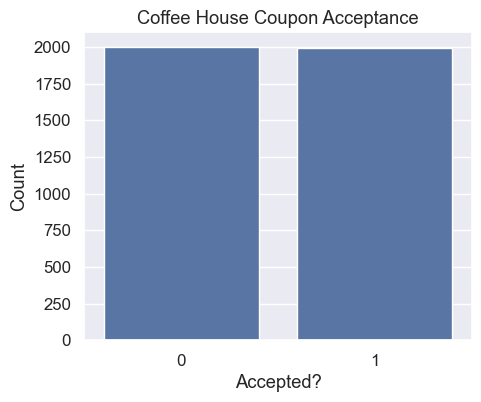

In [71]:
plt.figure(figsize=(5,4))
sns.countplot(data=coffee_df, x='Y')
plt.title('Coffee House Coupon Acceptance')
plt.xlabel('Accepted?')
plt.ylabel('Count')
plt.show()

## 8. Summary of findings (to fill in)

Use this section to briefly describe:
- Overall acceptance rate
- Key differences by coupon type
- Who tends to accept bar coupons
- Who tends to accept your chosen second coupon type
- 2–3 concrete marketing recommendations.

The analysis of the in‑vehicle coupon dataset shows meaningful differences in who accepts driving coupons and under what conditions.

### Overall acceptance patterns

Across all coupon types, a substantial share of drivers accept coupons, but acceptance varies by offer type and customer behavior. Coupons for venues that people visit more frequently (such as less expensive restaurants and coffee houses) tend to have higher acceptance rates than coupons for less frequently visited or more expensive venues.

### Bar coupon insights
Drivers who go to bars more often are noticeably more likely to accept bar coupons than those who rarely or never go to bars. Acceptance is also higher when the driver is not traveling with children and when the trip is to a non‑urgent destination, suggesting that both habits and context matter for spontaneous stops.

### Other coupon types
For non‑bar coupons (for example, coffee houses or cheaper restaurants), acceptance is stronger among drivers whose regular behavior matches the offer type, such as those who already visit coffee houses several times per month. Time of day and trip purpose also play a role, with some coupon types working better at certain hours or when drivers are not commuting to work.

### Actionable recommendations
Target bar coupons to drivers who already visit bars at least once or twice per month, are not driving with kids, and are not headed to work.

Send coffee house or low‑cost restaurant coupons to frequent visitors during appropriate times of day (for example, morning or mid‑afternoon) and near typical destinations like work or school.

Use customer visit frequency, passenger type, and trip context as key features for deciding when and to whom to deliver coupons, in order to improve overall acceptance rates.

